In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
BASE_DIR = "/gws/nopw/j04/ai4er/users/pn341/climate-rl-f2py/cm-v6"
DATASETS_DIR = f"{BASE_DIR}/datasets"

fp_Ts = f"{DATASETS_DIR}/skt.sfc.mon.1981-2010.ltm.nc"
fp_ulwrf = f"{DATASETS_DIR}/ulwrf.ntat.mon.1981-2010.ltm.nc"
fp_dswrf = f"{DATASETS_DIR}/dswrf.ntat.mon.1981-2010.ltm.nc"
fp_uswrf = f"{DATASETS_DIR}/uswrf.ntat.mon.1981-2010.ltm.nc"

ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"


def download_and_save_dataset(url, filepath, dataset_name):
    if not os.path.exists(filepath):
        print(f"Downloading {dataset_name} data ...")
        dataset = xr.open_dataset(url, decode_times=False)
        dataset.to_netcdf(filepath, format="NETCDF3_64BIT")
        print(f"{dataset_name} data saved to {filepath}")
    else:
        print(f"Loading {dataset_name} data ...")
        dataset = xr.open_dataset(
            filepath, decode_times=xr.coders.CFDatetimeCoder(use_cftime=True)
        )
    return dataset


ncep_Ts = download_and_save_dataset(
    ncep_url + "surface_gauss/skt.sfc.mon.1981-2010.ltm.nc",
    fp_Ts,
    "NCEP surface temperature",
)
ncep_ulwrf = download_and_save_dataset(
    ncep_url + "other_gauss/ulwrf.ntat.mon.1981-2010.ltm.nc",
    fp_ulwrf,
    "NCEP upwelling longwave radiation",
)
ncep_dswrf = download_and_save_dataset(
    ncep_url + "other_gauss/dswrf.ntat.mon.1981-2010.ltm.nc",
    fp_dswrf,
    "NCEP downwelling shortwave radiation",
)
ncep_uswrf = download_and_save_dataset(
    ncep_url + "other_gauss/uswrf.ntat.mon.1981-2010.ltm.nc",
    fp_uswrf,
    "NCEP upwelling shortwave radiation",
)

Loading NCEP surface temperature data ...
Loading NCEP upwelling longwave radiation data ...
Loading NCEP downwelling shortwave radiation data ...
Loading NCEP upwelling shortwave radiation data ...


In [3]:
ncep_Ts

<xarray.Dataset> Size: 2MB
Dimensions:             (lon: 192, time: 12, lat: 94, nbnds: 2)
Coordinates:
  * lon                 (lon) float32 768B 0.0 1.875 3.75 ... 354.4 356.2 358.1
  * time                (time) object 96B 0001-01-01 00:00:00 ... 0001-12-01 ...
  * lat                 (lat) float32 376B 88.54 86.65 84.75 ... -86.65 -88.54
Dimensions without coordinates: nbnds
Data variables:
    climatology_bounds  (time, nbnds) object 192B ...
    skt                 (time, lat, lon) float32 866kB ...
    valid_yr_count      (time, lat, lon) float32 866kB ...
Attributes:
    title:                          4x daily NMC reanalysis
    description:                    Data is from NMC initialized reanalysis\n...
    platform:                       Model
    Conventions:                    COARDS
    not_missing_threshold_percent:  minimum 3% values input to have non-missi...
    history:                        Created 2011/07/12 by doMonthLTM\nConvert...
    dataset_title:                  NCEP-NCAR Reanalysis 1
    References:                     http://www.psl.noaa.gov/data/gridded/data...
    _NCProperties:                  version=2,netcdf=4.6.3,hdf5=1.10.5

In [4]:
lat_ncep = ncep_Ts.lat
lon_ncep = ncep_Ts.lon
Ts_ncep_annual = ncep_Ts.skt.mean(dim=("lon", "time"))

OLR_ncep_annual = ncep_ulwrf.ulwrf.mean(dim=("lon", "time"))
ASR_ncep_annual = (ncep_dswrf.dswrf - ncep_uswrf.uswrf).mean(
    dim=("lon", "time")
)

In [5]:
plt.rcParams.update({"font.size": 12})

In [6]:
a0_ref = 0.354
a2_ref = 0.25
D_ref = 0.6
A_ref = 2.1
B_ref = 2

In [7]:
import climlab
import gymnasium as gym
from gymnasium import spaces
from matplotlib.gridspec import GridSpec


class EnergyBasedModelEnv(gym.Env):

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }

    def __init__(self, render_mode=None):

        self.min_D = 0.55
        self.max_D = 0.65

        self.min_A = 1.7
        self.max_A = 4.5

        self.min_B = 2
        self.max_B = 2

        self.min_a0 = 0.3
        self.max_a0 = 0.4

        self.min_a2 = 0.2
        self.max_a2 = 0.3

        self.min_temperature = -90
        self.max_temperature = 90

        self.action_space = spaces.Box(
            low=np.array(
                [
                    self.min_D,
                    *[self.min_A for x in range(len(Ts_ncep_annual))],
                    *[self.min_B for x in range(len(Ts_ncep_annual))],
                    self.min_a0,
                    self.min_a2,
                ],
                dtype=np.float32,
            ),
            high=np.array(
                [
                    self.max_D,
                    *[self.max_A for x in range(len(Ts_ncep_annual))],
                    *[self.max_B for x in range(len(Ts_ncep_annual))],
                    self.max_a0,
                    self.max_a2,
                ],
                dtype=np.float32,
            ),
            shape=(3 + 2 * len(Ts_ncep_annual),),
            dtype=np.float32,
        )
        self.observation_space = spaces.Box(
            low=self.min_temperature,
            high=self.max_temperature,
            shape=(len(lat_ncep),),
            dtype=np.float32,
        )

        assert (
            render_mode is None or render_mode in self.metadata["render_modes"]
        )

        self.render_mode = render_mode
        self.reset()

    def _get_obs(self):
        return self._get_temp()

    def _get_temp(self, model="RL"):
        if model == "RL":
            ebm = self.ebm
        elif model == "climlab":
            ebm = self.climlab_ebm
        temp = np.array(ebm.Ts, dtype=np.float32).reshape(-1)
        return temp

    def _get_info(self):
        return {"_": None}

    def _get_params(self):
        D = self.ebm.subprocess["diffusion"].D
        A, B = self.ebm.subprocess["LW"].A / 1e2, self.ebm.subprocess["LW"].B
        a0, a2 = (
            self.ebm.subprocess["albedo"].a0,
            self.ebm.subprocess["albedo"].a2,
        )
        params = np.array(
            [D, *(A.reshape(-1)), *(B.reshape(-1)), a0, a2], dtype=np.float32
        )
        return params

    def _get_state(self):
        state = self._get_temp()
        return state

    def step(self, action):
        D, a0, a2 = action[0], action[-2], action[-1]
        split_idx = 1 + len(Ts_ncep_annual)
        A = np.array(action[1:split_idx]).reshape(-1, 1)
        B = np.array(action[split_idx:-2]).reshape(-1, 1)

        D = np.clip(D, self.min_D, self.max_D)
        A = np.clip(A, self.min_A, self.max_A)
        B = np.clip(B, self.min_B, self.max_B)
        a0 = np.clip(a0, self.min_a0, self.max_a0)
        a2 = np.clip(a2, self.min_a2, self.max_a2)

        self.ebm.subprocess["diffusion"].D = D
        self.ebm.subprocess["LW"].A = A * 1e2
        self.ebm.subprocess["LW"].B = B
        self.ebm.subprocess["albedo"].a0 = a0
        self.ebm.subprocess["albedo"].a2 = a2

        self.ebm.step_forward()
        self.climlab_ebm.step_forward()

        costs = np.mean(
            (np.array(self.ebm.Ts.reshape(-1)) - Ts_ncep_annual.values[::-1])[
                15:-15
            ]
            ** 2
        )

        self.state = self._get_state()

        return self._get_obs(), -costs, False, False, self._get_info()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.ebm = climlab.EBM_annual(
            a0=a0_ref,
            a2=a2_ref,
            D=D_ref,
            A=np.array(
                [A_ref * 1e2 for x in range(len(Ts_ncep_annual))]
            ).reshape(-1, 1),
            B=np.array([B_ref for x in range(len(Ts_ncep_annual))]).reshape(
                -1, 1
            ),
            num_lat=len(lat_ncep),
            name="EBM Model w/ RL",
        )
        self.ebm.Ts[:] = 50.0

        # Initialize a climlab EBM model clone
        self.climlab_ebm = climlab.process_like(self.ebm)
        self.climlab_ebm.name = "EBM Model"

        self.state = self._get_state()
        return self._get_obs(), self._get_info()

    def _render_frame(self, save_fig=None, idx=None):
        fig = plt.figure(figsize=(28, 8))
        gs = GridSpec(1, 3, figure=fig)

        params = self._get_params()

        # Left subplot: diffusivity as bar plot
        ax1 = fig.add_subplot(gs[0, 0])

        ax1_labels = ["D", "A", "B", "a0", "a2"]
        ax1_colors = [
            "tab:blue",
            "tab:blue",
            "tab:blue",
            "tab:blue",
            "tab:blue",
        ]
        ax1_bars = ax1.bar(
            ax1_labels,
            [
                params[0],
                np.mean(params[1 : len(Ts_ncep_annual) + 1]),
                np.mean(params[len(Ts_ncep_annual) + 1 : -2]),
                *params[-2:],
            ],
            color=ax1_colors,
            width=0.75,
        )
        ax1.set_ylim(0, 10)
        ax1.set_ylabel("Value", fontsize=14)

        # Add values on top of the bars
        for bar in ax1_bars:
            height = bar.get_height()
            ax1.annotate(
                f"{height:.2f}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

        # Middle subplot: Temperature v/s Latitude
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.plot(self.ebm.lat, self.ebm.Ts, label="EBM Model w/ RL")
        ax2.plot(self.climlab_ebm.lat, self.climlab_ebm.Ts, label="EBM Model")
        ax2.plot(lat_ncep, Ts_ncep_annual, label="Observations", c="k")
        ax2.set_ylabel("Temperature (°C)")
        ax2.set_xlabel("Latitude")
        ax2.set_xlim(-90, 90)
        ax2.set_xticks(np.arange(-90, 91, 30))
        ax2.legend()
        ax2.grid()

        # Right subplot: Error v/s Latitude
        ax3 = fig.add_subplot(gs[0, 2])
        ax3.bar(
            x=self.ebm.lat,
            height=np.abs(
                self.ebm.Ts.reshape(-1) - Ts_ncep_annual.values[::-1]
            ),
            label="EBM Model w/ RL",
        )
        ax3.bar(
            x=self.climlab_ebm.lat,
            height=np.abs(
                self.climlab_ebm.Ts.reshape(-1) - Ts_ncep_annual.values[::-1]
            ),
            label="EBM Model",
            zorder=-1,
        )
        ax3.set_ylabel("Error  (°C)")
        ax3.set_xlabel("Latitude")
        ax3.set_xlim(-90, 90)
        ax3.set_xticks(np.arange(-90, 91, 30))
        ax3.legend()
        ax3.grid()

        return fig

    def render(self, **kwargs):
        if self.render_mode == "human":
            self._render_frame(**kwargs)
            plt.show()
        elif self.render_mode == "rgb_array":
            fig = self._render_frame(**kwargs)
            fig.canvas.draw()
            width, height = fig.canvas.get_width_height()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
            image = image.reshape((height, width, 3))
            plt.close(fig)
            return image

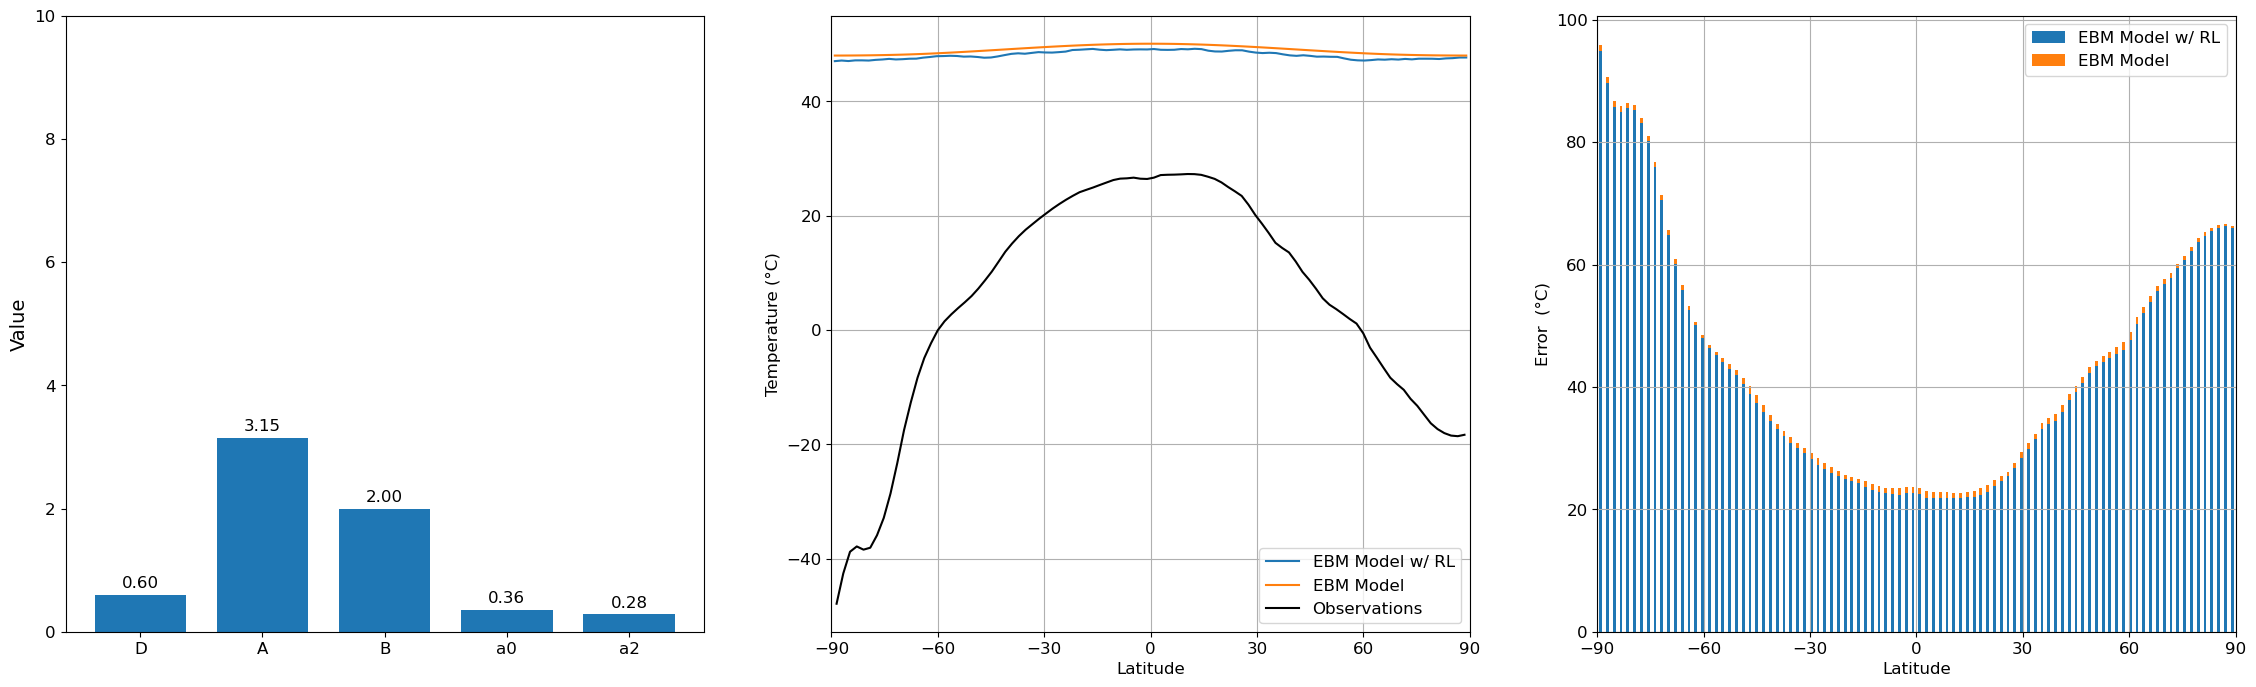

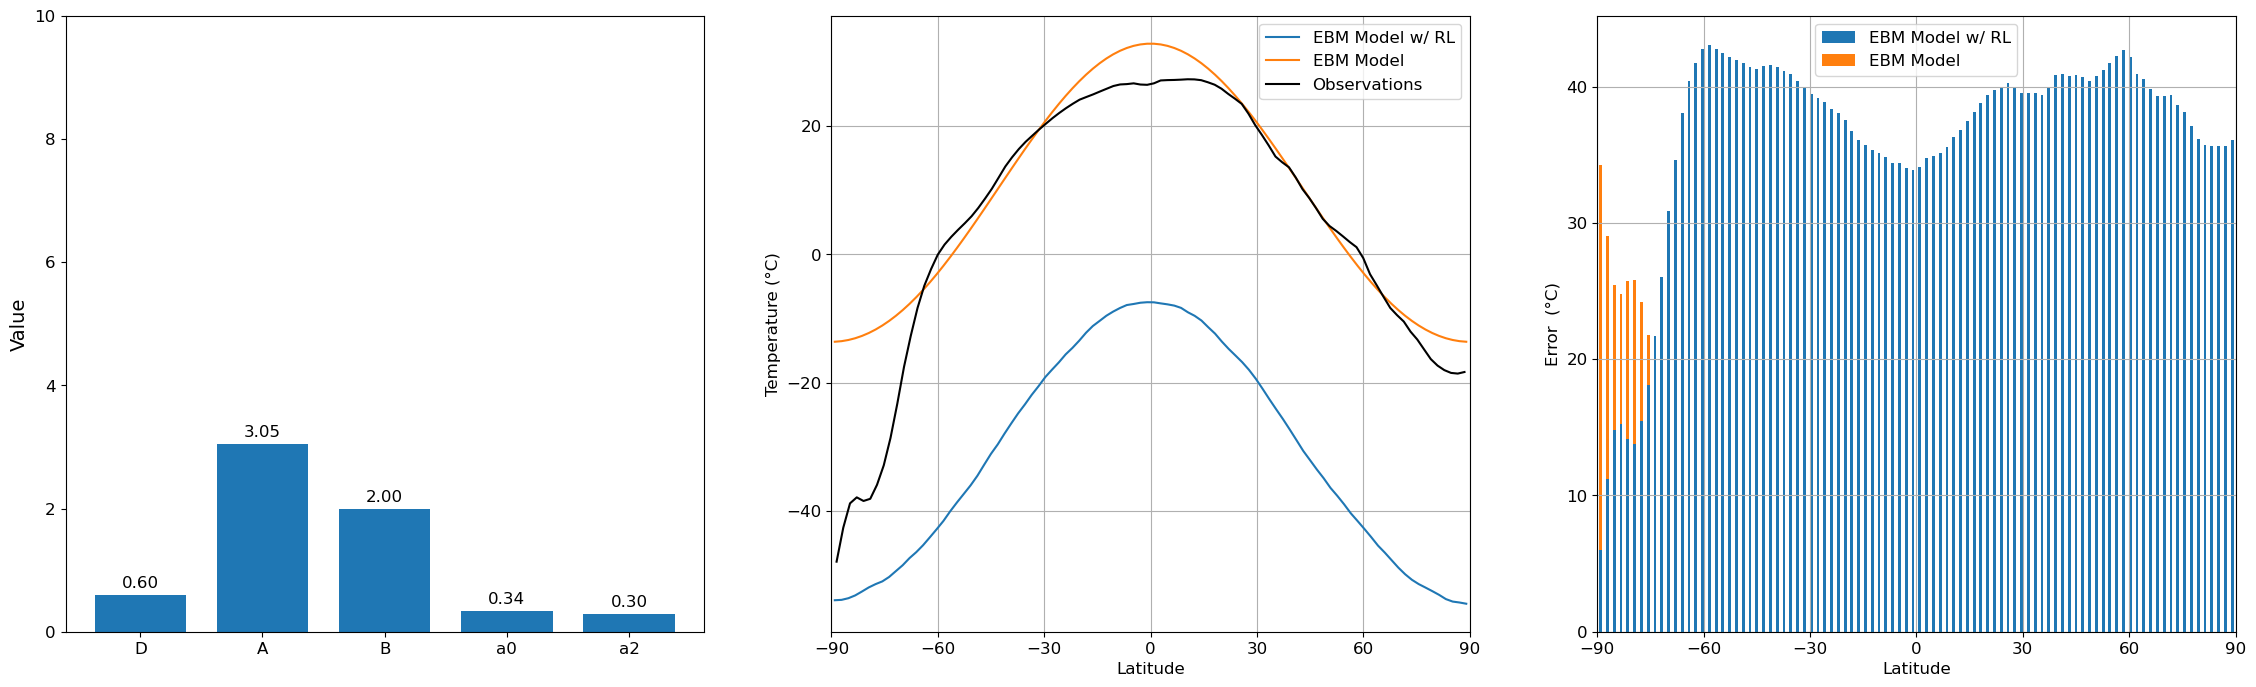

-----
episodic_return=[-59369.67966188461]
-----



In [8]:
# RL Environment [Random Actions]


seed = 1
env = EnergyBasedModelEnv(render_mode="human")
env.action_space.seed(seed=seed)
obs, _ = env.reset(seed=seed)
episodic_return = 0

for idx in range(100):
    action = env.action_space.sample()

    next_obs, rewards, terminations, truncations, infos = env.step(action)
    episodic_return += rewards

    if (idx == 0) or (idx % 100 == 99):
        env.render(save_fig=False, idx=idx)

print(f"-----\nepisodic_return=[{episodic_return}]\n-----\n")
env.close()